In [3]:
import torch
import torch.nn as nn

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5,1,2)
        self.pool1 = nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5,1)
        self.pool2 = nn.AvgPool2d(2,2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(576,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = torch.sigmoid(self.conv1(x))
        x = self.pool1(x)
        x = torch.sigmoid(self.conv2(x))
        x = self.flat(self.pool2(x))
        x = self.fc3(self.fc2(self.fc1(x)))
        probs = F.softmax(x, dim=1)
        return x, probs
LeNet()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [14]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'mps' if torch.backends.mps.is_built() else 'cpu'
DEVICE = "cpu"

In [15]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [16]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

In [17]:

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()

    # change the plot style to default
    plt.style.use('default')

In [24]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)


In [25]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)


AttributeError: 'Compose' object has no attribute 'Compose'

In [26]:
ROW_IMG = 10
N_ROWS = 5

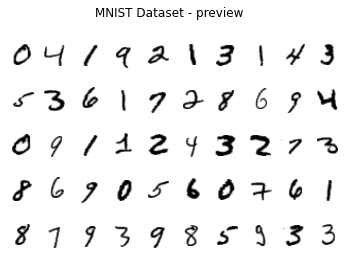

In [27]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index],cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');


In [28]:
torch.manual_seed(RANDOM_SEED)
model = LeNet()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


01:26:20 --- Epoch: 0	Train loss: 0.6168	Valid loss: 0.1974	Train accuracy: 93.47	Valid accuracy: 93.83
01:26:44 --- Epoch: 1	Train loss: 0.1377	Valid loss: 0.0914	Train accuracy: 96.97	Valid accuracy: 97.11
01:27:09 --- Epoch: 2	Train loss: 0.0966	Valid loss: 0.0695	Train accuracy: 97.56	Valid accuracy: 97.73
01:27:34 --- Epoch: 3	Train loss: 0.0799	Valid loss: 0.0763	Train accuracy: 97.47	Valid accuracy: 97.60
01:27:59 --- Epoch: 4	Train loss: 0.0698	Valid loss: 0.0547	Train accuracy: 98.37	Valid accuracy: 98.37
01:28:23 --- Epoch: 5	Train loss: 0.0623	Valid loss: 0.0630	Train accuracy: 98.09	Valid accuracy: 97.90
01:28:48 --- Epoch: 6	Train loss: 0.0558	Valid loss: 0.0468	Train accuracy: 98.52	Valid accuracy: 98.55
01:29:12 --- Epoch: 7	Train loss: 0.0513	Valid loss: 0.0524	Train accuracy: 98.65	Valid accuracy: 98.29
01:29:38 --- Epoch: 8	Train loss: 0.0476	Valid loss: 0.0500	Train accuracy: 98.63	Valid accuracy: 98.43
01:30:04 --- Epoch: 9	Train loss: 0.0443	Valid loss: 0.0487	Trai

/var/folders/8q/z1bbrqxx6dv_tznknzl2vstr0000gn/T/ipykernel_88295/1764952481.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(LeNet(
   (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
   (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
   (flat): Flatten(start_dim=1, end_dim=-1)
   (fc1): Linear(in_features=576, out_features=120, bias=True)
   (fc2): Linear(in_features=120, out_features=84, bias=True)
   (fc3): Linear(in_features=84, out_features=10, bias=True)
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     eps: 1e-08
     foreach: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 ([0.6168282765418291,
   0.1376760282345116,
   0.09657176338123778,
   0.0798612218843773,
   0.06984199193427339,
   0.0623422962905063,
   0.05581723422153542,
   0.05132788248703194,
   0.04761967492230858,
   0.04426633035638369,
   0.041575102811174776,
   0.03917724534448547,
   0.037175094762215546,
   0

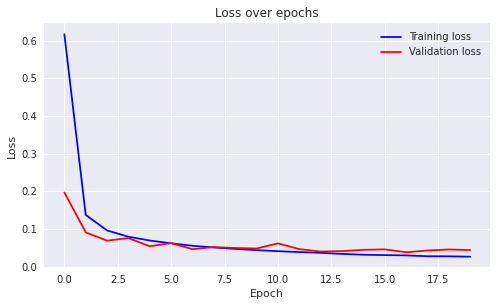

In [29]:
training_loop(model,criterion,optimizer,train_loader,valid_loader,20,DEVICE,1)

In [52]:
for i,j in valid_loader:
    x = i[0]
    break;
x = torch.unsqueeze(x,0)
x.shape

torch.Size([1, 1, 32, 32])

In [55]:
with torch.no_grad():
    result = model(x)

In [68]:
result[1].sum(1)
print( result[1])
torch.argmax(result[1]).item()

tensor([[4.1747e-13, 2.8603e-10, 2.0180e-09, 1.1597e-07, 6.9926e-11, 5.3075e-10,
         1.2507e-15, 1.0000e+00, 2.2817e-11, 3.4594e-09]])


7

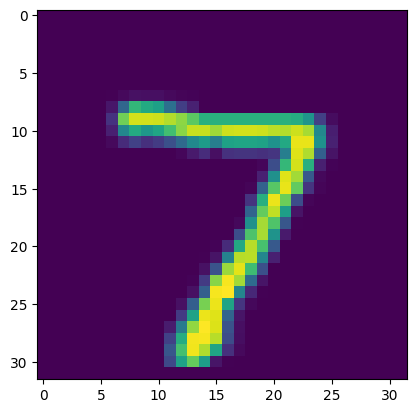

In [79]:
plt.imshow(torch.squeeze(x,0).permute(1,2,0))

In [87]:
with torch.no_grad():
    conv1_results = torch.squeeze(model.conv1(x))

with torch.no_grad():
    conv1_results = torch.squeeze(model.conv1(x))

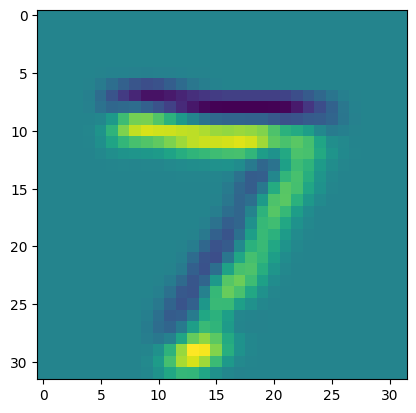

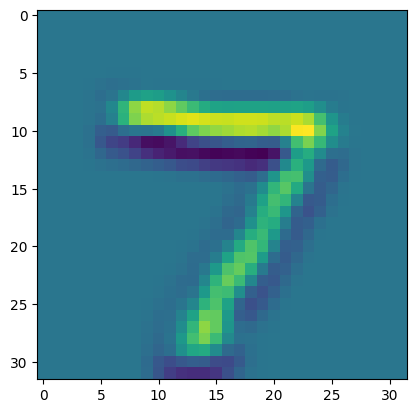

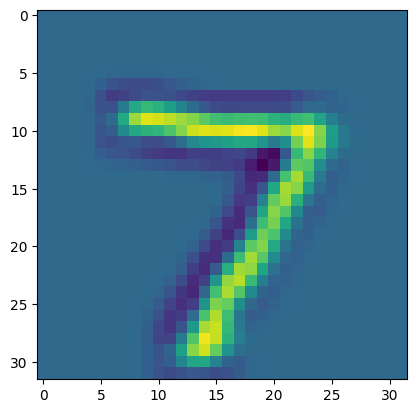

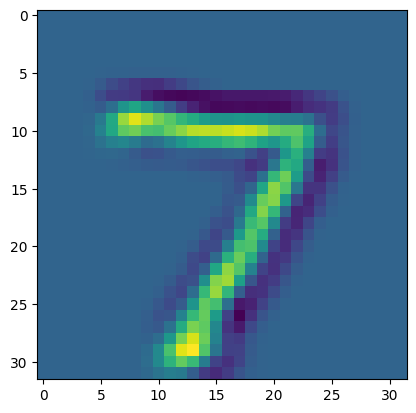

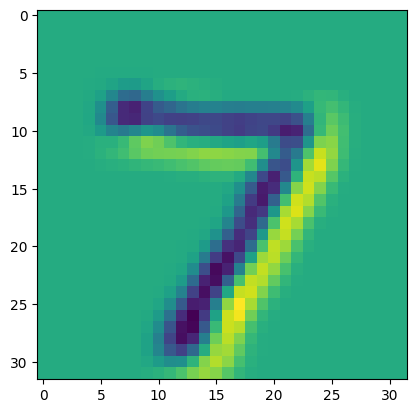

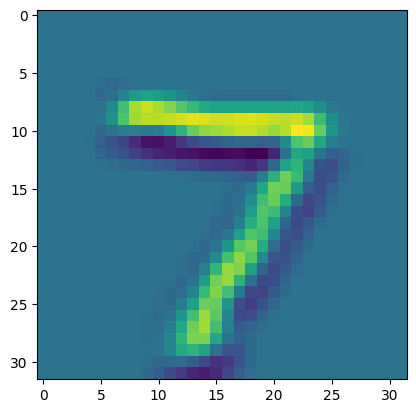

In [89]:
for p in conv1_results:
    plt.imshow(torch.unsqueeze(p,0).permute(1,2,0))
    plt.show()
